In [2]:
"""Import Libraries"""

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

import matplotlib.pyplot as plt

2024-12-24 15:48:04.427101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 15:48:04.443912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 15:48:04.448615: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 15:48:04.459947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 15:48:05.187921: W tensorflow/compiler/tf2

In [28]:
"""Check if its using GPU"""

print(f"\nNum GPUs Available: {len(tf.config.list_physical_devices('GPU'))}\n")


Num GPUs Available: 1



In [3]:
"""Hyperparameters"""

SEED = 42
FOLDER_NAME = "flow_large"
IMAGE_SIZE = (192, 576)
BATCH_SIZE = 2
EPOCHS = 100
DATASET_REPETITION = 1
LATENT_DIM = 1024
CONV_WIDTHS = [32, 64, 128, 256, 512]
DENSE_WIDTHS = [(LATENT_DIM*2)]
KERNEL = 3
LEARNING_RATE = 2.5e-4
WEIGHT_DECAY = 2.5e-5

In [4]:
"""Load the Dataset"""

def load_dataset(): 
    """
    Loads the dataset for training
    """
    cwd = os.getcwd()
    img_dir = os.path.join(cwd, FOLDER_NAME)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        img_dir, 
        validation_split = None,
        subset=None, 
        seed = SEED,
        image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1]),  
        batch_size = None,
        shuffle = True,
        crop_to_aspect_ratio = True,
        pad_to_aspect_ratio = False,
    )
    return train_ds

In [5]:
"""Prepare the Dataset"""

def normalize_image(images, _):    
    # clip pixel values to the range [0, 1]
    return tf.clip_by_value(images / 255, 0.0, 1.0)

def prepare_dataset(train_ds): 
    """
    Prepares the dataset for training, used in combination with load_dataset
    """
    train_ds = (train_ds
                .map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE) # each dataset has the structure
                .cache()                                                   # (image, labels) when inputting to 
                .repeat(DATASET_REPETITION)                                # map
                .shuffle(10 * BATCH_SIZE)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
    return train_ds

Found 10409 files belonging to 1 classes.


I0000 00:00:1735073293.143370  125849 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073293.181897  125849 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073293.182078  125849 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1735073293.182949  125849 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

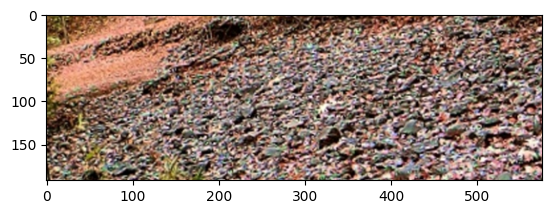

In [6]:
"""Load and Prepare Dataset and Show Sample Image"""

# load and prepare the dataset
dataset = load_dataset()
training_dataset = prepare_dataset(dataset)

# showcase the first image in the iterator
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

plt.imshow(img)
plt.show()

In [7]:
"""Sampling layer"""

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


In [8]:
"""Build the Encoder"""

def Build_Encoder(): 
    """Potentially add block depth onto the model in the future to check performance"""
    encoder_inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Conv2D(CONV_WIDTHS[0], KERNEL, activation="relu", strides=2, padding="same")(encoder_inputs)
    for width in CONV_WIDTHS[1:]: 
        x = layers.Conv2D(width, KERNEL, activation="relu", strides=2, padding="same")(x) 
        print(x)
    x = layers.Flatten()(x)
    for width in DENSE_WIDTHS[:]: 
        x = layers.Dense(width, activation="relu")(x)
        print(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder = Build_Encoder()
encoder.summary()

<KerasTensor shape=(None, 48, 144, 64), dtype=float32, sparse=False, name=keras_tensor_2>
<KerasTensor shape=(None, 24, 72, 128), dtype=float32, sparse=False, name=keras_tensor_3>
<KerasTensor shape=(None, 12, 36, 256), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, 6, 18, 512), dtype=float32, sparse=False, name=keras_tensor_5>
<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_7>


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 576,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 288,   │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 144,   │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 72,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 36,    │    295,168 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 6, 18,     │  1,180,160 │ conv2d_3[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 55296)     │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │ 113,248,2… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 1024)      │  2,098,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 1024)      │  2,098,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 1024)      │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,013,184 (454.00 MB)

 Trainable params: 119,013,184 (454.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
"""Build the Decoder"""

from math import prod

# need to manually set this value if you 
# change model architecture
final_shape = (6, 18, 512)

def Build_Decoder(): 
    """Potentially add block depth onto the model in the future to check performance"""
    latent_inputs = keras.Input(shape=(LATENT_DIM, ))
    print(latent_inputs)
    x = layers.Dense(DENSE_WIDTHS[-1], activation="relu")(latent_inputs)
    if len(DENSE_WIDTHS) > 1: 
        for width in DENSE_WIDTHS[-2::-1]: 
            x = layers.Dense(width, activation="relu")(x)
            print(x)
    x = layers.Dense(prod(final_shape), activation="relu")(x)
    x = layers.Reshape(final_shape)(x)
    for width in CONV_WIDTHS[::-1]: 
        x = layers.Conv2DTranspose(width, KERNEL, activation="relu", strides=2, padding="same")(x) 
        print(x)
    decoder_outputs = layers.Conv2DTranspose(3, KERNEL, activation="sigmoid", padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder = Build_Decoder()
decoder.summary()

<KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_11>
<KerasTensor shape=(None, 12, 36, 512), dtype=float32, sparse=False, name=keras_tensor_15>
<KerasTensor shape=(None, 24, 72, 256), dtype=float32, sparse=False, name=keras_tensor_16>
<KerasTensor shape=(None, 48, 144, 128), dtype=float32, sparse=False, name=keras_tensor_17>
<KerasTensor shape=(None, 96, 288, 64), dtype=float32, sparse=False, name=keras_tensor_18>
<KerasTensor shape=(None, 192, 576, 32), dtype=float32, sparse=False, name=keras_tensor_19>


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 55296)          │   113,301,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 18, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 12, 36, 512)    │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 24, 72, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 48, 144, 128)   │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 288, 64)    │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 192, 576, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 192, 576, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,328,579 (455.20 MB)

 Trainable params: 119,328,579 (455.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
"""Build the VAE"""

class VAE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Build_Encoder()
        self.decoder = Build_Decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print("passed")
        with tf.GradientTape() as tape:
            print("passed")
            z_mean, z_log_var, z = self.encoder(data)
            print("passed")
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
"""Train the VAE"""

CHECKPOINT_PATH = "checkpoints/best.ckpt"

# Create a callback that saves teh models' weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, 
                                                         save_best_only=True, 
                                                         verbose=1)

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    callbacks=[checkpoint_callback]
))
vae.fit(x=training_dataset, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE)

<_PrefetchDataset element_spec=TensorSpec(shape=(2, 192, 576, 3), dtype=tf.float32, name=None)>
<KerasTensor shape=(None, 48, 144, 64), dtype=float32, sparse=False, name=keras_tensor_23>
<KerasTensor shape=(None, 24, 72, 128), dtype=float32, sparse=False, name=keras_tensor_24>
<KerasTensor shape=(None, 12, 36, 256), dtype=float32, sparse=False, name=keras_tensor_25>
<KerasTensor shape=(None, 6, 18, 512), dtype=float32, sparse=False, name=keras_tensor_26>
<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_28>
<KerasTensor shape=(None, 12, 36, 512), dtype=float32, sparse=False, name=keras_tensor_36>
<KerasTensor shape=(None, 24, 72, 256), dtype=float32, sparse=False, name=keras_tensor_37>
<KerasTensor shape=(None, 48, 144, 128), dtype=float32, sparse=False, name=keras_tensor_38>
<KerasTensor shape=(None, 96, 288, 64), dtype=float32, sparse=False, name=keras_tensor_39>
<KerasTensor shape=(None, 192, 576, 32), dtype=float32, sparse=False, name=keras_tensor_40>


I0000 00:00:1735014098.828041  103581 service.cc:146] XLA service 0x76c064002d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735014098.828071  103581 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-12-23 23:21:38.974054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-23 23:21:39.480130: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-23 23:21:40.509862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



   1/5204 ━━━━━━━━━━━━━━━━━━━━ 19:15:26 13s/step - kl_loss: 0.2598 - loss: 76658.6172 - reconstruction_loss: 76653.3125

I0000 00:00:1735014108.809207  103581 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5204/5204 ━━━━━━━━━━━━━━━━━━━━ 252s 46ms/step - kl_loss: 58.0369 - loss: 70905.9453 - reconstruction_loss: 70847.8516
Epoch 2/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 129.7105 - loss: 68151.5156 - reconstruction_loss: 68021.7578
Epoch 3/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 144.4435 - loss: 67266.4844 - reconstruction_loss: 67122.0078
Epoch 4/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 151.4759 - loss: 66874.3594 - reconstruction_loss: 66722.8906
Epoch 5/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 157.9237 - loss: 66622.6172 - reconstruction_loss: 66464.7109
Epoch 6/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 163.8228 - loss: 66431.1641 - reconstruction_loss: 66267.3750
Epoch 7/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 166.9560 - loss: 66273.8125 - reconstruction_loss: 66106.9297
Epoch 8/100
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 238s 46ms/step - kl_loss: 170.2321 - loss: 66166.0703

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


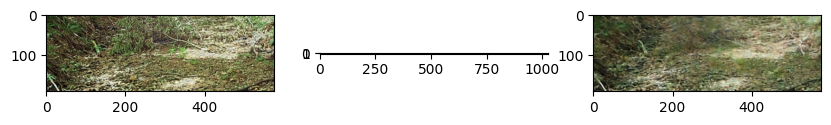

In [ ]:
"""Demonstrate Visual Output/Performance of VAE"""

import matplotlib.pyplot as plt

# inference
# latent_dim = 2
# z_sample = np.random.normal(size=(1, latent_dim))
# generated_sample = vae.decoder.predict(z_sample)

# get img
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

# encoder
z_mean, z_log_var, z = vae.encoder.predict(batches)

# decoder
generated_sample = vae.decoder.predict(z)

# create plots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# show img
axes[0].imshow(img)
axes[1].imshow(z)
axes[2].imshow(generated_sample[0])

#plt.imshow(generated_sample[0])
plt.show()

In [24]:
"""Save the Image for Better Visualization"""

import cv2 as cv

scaled_img = img * 255
scaled_generated_sample = generated_sample[0] * 255

clipped_img = np.clip(scaled_img, 0, 255).astype(np.uint8)
clipped_generated_sample = np.clip(scaled_generated_sample, 0, 255).astype(np.uint8)

cv.imwrite("original_img3.jpg", clipped_img)
cv.imwrite("decoder_img3.jpg", clipped_generated_sample)

True

In [15]:
print(np.min(generated_sample[0]))
print(np.max(generated_sample[0]))

0.00021303314
0.9827183


In [ ]:
"""Save the Weights"""

vae.save_weights('vae_large.weights.h5')

<KerasTensor shape=(None, 48, 144, 64), dtype=float32, sparse=False, name=keras_tensor_86>
<KerasTensor shape=(None, 24, 72, 128), dtype=float32, sparse=False, name=keras_tensor_87>
<KerasTensor shape=(None, 12, 36, 256), dtype=float32, sparse=False, name=keras_tensor_88>
<KerasTensor shape=(None, 6, 18, 512), dtype=float32, sparse=False, name=keras_tensor_89>
<KerasTensor shape=(None, 2048), dtype=float32, sparse=False, name=keras_tensor_91>
<KerasTensor shape=(None, 1024), dtype=float32, sparse=False, name=keras_tensor_95>
<KerasTensor shape=(None, 12, 36, 512), dtype=float32, sparse=False, name=keras_tensor_99>
<KerasTensor shape=(None, 24, 72, 256), dtype=float32, sparse=False, name=keras_tensor_100>
<KerasTensor shape=(None, 48, 144, 128), dtype=float32, sparse=False, name=keras_tensor_101>
<KerasTensor shape=(None, 96, 288, 64), dtype=float32, sparse=False, name=keras_tensor_102>
<KerasTensor shape=(None, 192, 576, 32), dtype=float32, sparse=False, name=keras_tensor_103>


2024-12-24 15:49:14.541399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
(2, 1024)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


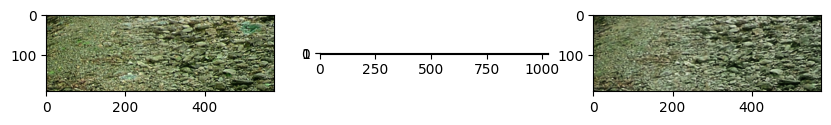

In [14]:
"""Load the Model for Inference"""

vae = VAE()
vae.load_weights("weights/vae_large.weights.h5")

# get img
iterator = training_dataset.as_numpy_iterator()
batches = next(iterator)
img = batches[0]

# encoder
z_mean, z_log_var, z = vae.encoder.predict(batches)

print(z.shape)

# decoder
generated_sample = vae.decoder.predict(z)

# create plots
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# show img
axes[0].imshow(img)
axes[1].imshow(z)
axes[2].imshow(generated_sample[0])

#plt.imshow(generated_sample[0])
plt.show()
